## **Visual Analysis: Top vs. Underperforming Categories**

This section visualizes the differences between the **top 5 performing** and **underperforming product categories** based on total sales. 

We explore three key business drivers to understand what contributes to underperformance:
- **Seller Count**: How many unique sellers are involved per category.
- **Order Volume**: The total number of orders per category.
- **Stock Variety**: Number of unique products listed per category.

These comparisons aim to answer the business question:
> "Why are some product categories underperforming?"

The goal is to identify actionable factors such as low seller presence or limited product variety that may hinder sales performance.

--- 


### **Data Preparation and Environment Setup**

This section initializes the environment for data analysis and visualization.

- **Pandas** is used for data manipulation and transformation.
- **SQLAlchemy** and **PyMySQL** are used to connect to and retrieve data from a MySQL database.
- **Matplotlib** and **Seaborn** are used for generating insightful visualizations.
- Plot aesthetics are customized using Seaborn’s whitegrid style and Matplotlib's muted theme for a clean and professional look.
---

In [ ]:
# Data Manipulation
import pandas as pd

# SQL Connection
import pymysql
from sqlalchemy import create_engine

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns

# Plot aesthetics
sns.set(style='whitegrid')
plt.style.use('seaborn-v0_8-muted')

---

### **Database Connection Setup**

We use SQLAlchemy to connect to the MySQL database. This allows us to run SQL queries and load the results directly into pandas for analysis.

---


In [2]:
host = 'localhost'
port = 3306
user = 'root'
password = 'mypass'
databae = 'ecommerce'

engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{databae}')

---

### **Loading Cleaned SQL Data into Pandas**

This query extracts essential columns by joining multiple relevant tables. It prepares the dataset for performance analysis of product categories.

#### **Joins and Their Purpose:**

- `orders o JOIN order_items oi ON o.order_id = oi.order_id`  
  → Links each order to its associated items.
  

- `JOIN product_category_name_translation t ON p.product_category_name = t.product_category_name`  
  → Translates Portuguese category names to English for better readability and analysis.

#### **Selected Fields**:

- `oi.product_id` — Identifies each unique product.  
- `t.product_category_name_english` — Product category in English.  
- `oi.seller_id` — Captures which seller provided the product.  
- `o.order_id` — Helps count the number of orders per product/category.  
- `oi.price` — Used to compute total sales and compare performance.

This data is loaded using `pd.read_sql()` for seamless integration into the Python environment, enabling further data manipulation and visualization.

---


In [111]:
query = """
SELECT 
    oi.product_id,
    t.product_category_name_english,
    oi.seller_id,
    o.order_id,
    oi.price 
FROM orders o
JOIN order_items oi 
    ON o.order_id = oi.order_id
JOIN products p 
    ON oi.product_id = p.product_id
JOIN product_category_name_translation t   
    ON p.product_category_name = t.product_category_name;
"""

df = pd.read_sql(query, engine)

---

### **Inspecting DataFrame Structure**

`df.info()` is used to check column types, non-null counts, and overall structure to ensure data was imported correctly before analysis.

---


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14188 entries, 0 to 14187
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     14188 non-null  object 
 1   product_category_name_english  14188 non-null  object 
 2   seller_id                      14188 non-null  object 
 3   order_id                       14188 non-null  object 
 4   price                          14188 non-null  float64
dtypes: float64(1), object(4)
memory usage: 554.3+ KB


---

### **Checking Data Types**

`df.dtypes` helps verify the data types of each column, ensuring correct formats (e.g., datetime, numeric, object) for further manipulation and visualization.

---


In [88]:
df.dtypes

product_id                        object
product_category_name_english     object
seller_id                         object
order_id                          object
product_photos_qty               float64
price                            float64
dtype: object

---

### **Previewing the Dataset**

`df.head()` displays the first few rows of the dataset, giving a quick overview of its structure, values, and potential issues such as missing or inconsistent data.

---


In [113]:
df.head()

,product_id,product_category_name_english,seller_id,order_id,price
0,b5c114b11d53b6fd85a6a90790f0b479,housewares,0adac9fbd9a2b63cccaac4f8756c1ca8,01a75ac3dd000b7628a684be97c29234,42.90
1,78119fbfa709d07b86f5ccf15043c6d6,cool_stuff,b33e7c55446eabf8fe1a42d037ac7d6d,21f4a37ec131158f1615d0f186f190af,199.98
2,19c91ef95d509ea33eda93495c4d3481,health_beauty,06a2c3af7b3aee5d69171b0e14f0ee87,0d09617395364c88c4ad7c457b439314,122.99
3,84e1b9c6ba2ed178bd217097b41f1251,kitchen_dining_laundry_garden_furniture,1b938a7ec6ac5061a66a3766e0e75f90,112f6cd3047e7f158607233e26206398,74.90
4,bbaef2eadf31fe3ea6702077398be06c,perfumery,cc419e0650a3c5ba77189a1882b7556a,01835ef41c5ac66dd9ec6084fa1d0533,56.99


---

### **Cleaning Product Category Names**

We standardized the `product_category_name_english` column by:
- Replacing underscores with spaces
- Removing leading/trailing spaces
- Converting all text to lowercase

> **Note:** During previous analysis, we identified a typo (`fashio female clothing`) and corrected it to `fashion female clothing` for consistency.

---


In [114]:
df['product_category_name_english'] = (df['product_category_name_english'].astype('str').str.replace('_', ' ').str.strip().str.lower())
df['product_category_name_english'] = df['product_category_name_english'].replace('fashio female clothing', 'fashion female clothing')

---

### **Identifying Top and Underperforming Categories**

To evaluate product category performance:

- We calculated total sales per category by grouping the data on `product_category_name_english` and summing the `price`.
- Categories with **sales greater than 2000** were classified as **top-performing**.
- Categories with **sales less than or equal to 2000** were considered **underperforming**.

This segmentation enables targeted analysis and visualization of factors influencing product performance.

---


In [115]:
category_sales = df.groupby('product_category_name_english')['price'].sum().reset_index()

top_categories = category_sales[category_sales['price'] > 2000]['product_category_name_english'].tolist()
underperforming_categories = category_sales[category_sales['price'] <= 2000]['product_category_name_english'].tolist()


---

### **Segregating Data for Performance-Based Analysis**

Using the previously defined lists of top-performing and underperforming categories,  
we filtered the main dataset into two subsets:

- `top_df`: contains records for **top-performing categories**
- `underperforming_df`: contains records for **underperforming categories**

This allows for focused comparisons in terms of seller count, order volume, and product availability.

---


In [119]:
top_df = df[df['product_category_name_english'].isin(top_categories)]
underperforming_df = df[df['product_category_name_english'].isin(underperforming_categories)]

---

### **Top 5 Product Categories by Sales**

This bar chart displays the five product categories with the highest total sales, based on aggregated `price` values. Categories were sorted in descending order to identify the top performers.

This visualization helps highlight where the majority of revenue is generated, providing business insight into the most successful product segments.

---


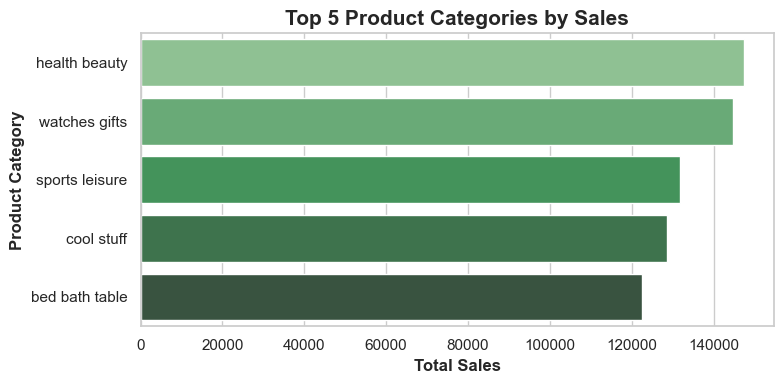

In [121]:
top_5_sales = (
    category_sales
    .sort_values(by='price', ascending=False)
    .head(5)
)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=top_5_sales,
    x='price',
    y='product_category_name_english',
    hue='product_category_name_english', 
    palette='Greens_d',
    legend=False  
)
plt.title('Top 5 Product Categories by Sales', fontsize=15, fontweight='bold')
plt.xlabel('Total Sales', fontsize=12, fontweight='bold')
plt.ylabel('Product Category', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../visuals/top_5_product_categories_by_sales.png', dpi=600, bbox_inches='tight')
plt.show()


---

### **Top 5 Underperforming Categories by Sales**

This bar chart shows the five product categories with the lowest total sales, based on the aggregated `price` values. These categories were identified by sorting in ascending order and selecting those with minimal revenue contribution.

This visualization supports the business analysis by highlighting product categories that may require attention for potential improvement or strategic review.

---


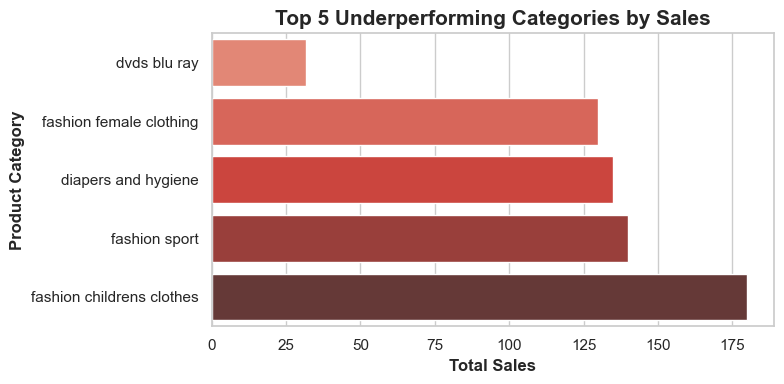

In [122]:
under_5_sales = (
    underperforming_df
    .groupby('product_category_name_english')['price']
    .sum()
    .reset_index()
    .sort_values(by='price')
    .head(5)
)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=under_5_sales,
    x='price',
    y='product_category_name_english',
    hue='product_category_name_english',  
    palette='Reds_d',
    legend=False
)

plt.title('Top 5 Underperforming Categories by Sales', fontsize=15, fontweight='bold')
plt.xlabel('Total Sales', fontsize=12, fontweight='bold')
plt.ylabel('Product Category', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../visuals/top_5_underperforming_product_categories_by_sales.png', dpi=600, bbox_inches='tight')
plt.show()


---

### **Seller Count - Top 5 Product Categories**

This chart shows the number of **unique sellers** in the top 5 product categories by total sales. These categories demonstrate a high seller count, suggesting strong competition and availability across multiple vendors.

---


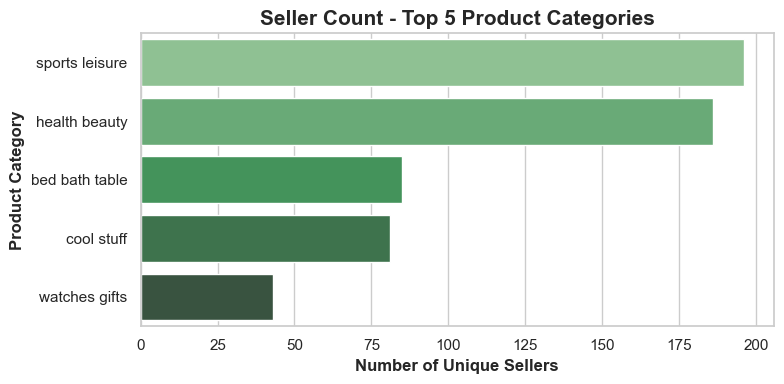

In [123]:
top_seller_counts = (
    top_df[top_df['product_category_name_english'].isin(top_5_sales['product_category_name_english'])]
    .groupby('product_category_name_english')['seller_id']
    .nunique()
    .reset_index(name='seller_count')
    .sort_values(by='seller_count', ascending=False)
)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=top_seller_counts,
    x='seller_count',
    y='product_category_name_english',
    hue='product_category_name_english',  
    palette='Greens_d',
    legend=False                           
)
plt.title('Seller Count - Top 5 Product Categories', fontsize=15, fontweight='bold')
plt.xlabel('Number of Unique Sellers', fontsize=12, fontweight='bold')
plt.ylabel('Product Category', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../visuals/seller_count-top_performers.png', dpi=600, bbox_inches='tight')
plt.show()


---

### **Seller Count - Underperforming Categories**

This visualization presents the number of **unique sellers** in the top 5 underperforming product categories based on total sales. These categories exhibit **significantly lower seller counts**, indicating reduced availability and limited competition.

**Business Insight:**  
A low number of sellers in these categories is a primary factor contributing to their underperformance. Limited seller presence often leads to less product variety, decreased customer options, and ultimately lower sales volume.

---


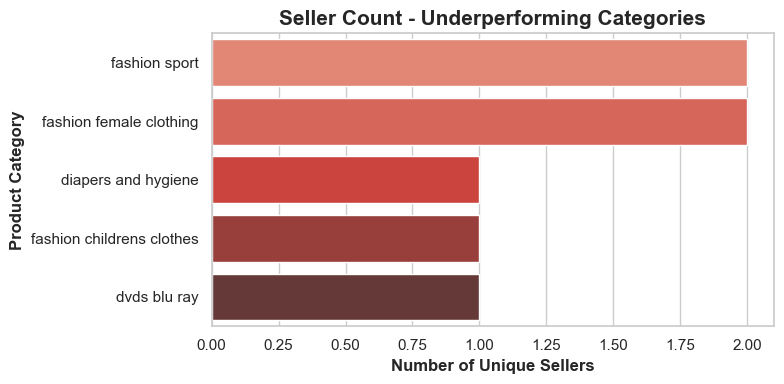

In [124]:
under_seller_counts = (
    underperforming_df[underperforming_df['product_category_name_english'].isin(under_5_sales['product_category_name_english'])]
    .groupby('product_category_name_english')['seller_id']
    .nunique()
    .reset_index(name='seller_count')
    .sort_values(by='seller_count', ascending=False)
)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=under_seller_counts,
    x='seller_count',
    y='product_category_name_english',
    hue='product_category_name_english',
    palette='Reds_d',
    legend=False
)
plt.title('Seller Count - Underperforming Categories', fontsize=15, fontweight='bold')
plt.xlabel('Number of Unique Sellers', fontsize=12, fontweight='bold')
plt.ylabel('Product Category', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../visuals/seller_count-underperformers.png', dpi=600, bbox_inches='tight')
plt.show()



---

### **Order Count - Top 5 Product Categories by Sales**

This visualization shows the number of **unique orders** in the top 5 product categories based on total sales. These categories consistently have **high order volumes**, aligning with their strong sales performance.

---


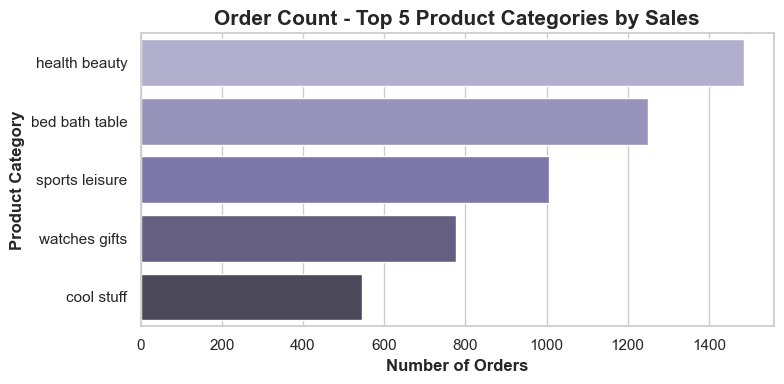

In [126]:
top_5_order_counts = (
    top_df[top_df['product_category_name_english'].isin(top_5_sales['product_category_name_english'])]
    .groupby('product_category_name_english')['order_id']
    .nunique()
    .reset_index(name='order_count')
    .sort_values(by='order_count', ascending=False)
)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=top_5_order_counts,
    x='order_count',
    y='product_category_name_english',
    hue='product_category_name_english',
    palette='Purples_d',
    legend=False
)
plt.title('Order Count - Top 5 Product Categories by Sales', fontsize=15, fontweight='bold')
plt.xlabel('Number of Orders', fontsize=12, fontweight='bold')
plt.ylabel('Product Category', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../visuals/order_count-top_performers.png', dpi=600, bbox_inches='tight')
plt.show()


---

### **Order Count - Underperforming Product Categories**

This visualization displays the **number of unique orders** across the five most underperforming product categories. These categories exhibit **significantly lower order volumes** compared to top-performing ones.

**Business Insight:**  
The low order count is largely a result of **fewer active sellers and lower market presence**, which limits the availability of products in these categories and contributes directly to their underperformance.

---


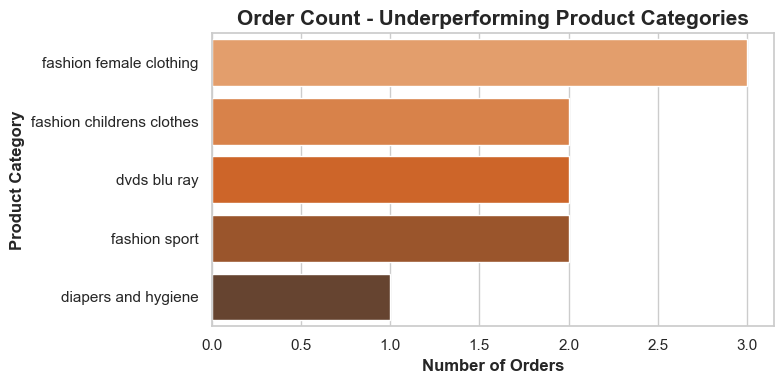

In [127]:
under_5_order_counts = (
    underperforming_df[underperforming_df['product_category_name_english'].isin(under_5_sales['product_category_name_english'])]
    .groupby('product_category_name_english')['order_id']
    .nunique()
    .reset_index(name='order_count')
    .sort_values(by='order_count', ascending=False)
)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=under_5_order_counts,
    x='order_count',
    y='product_category_name_english',
    hue='product_category_name_english',
    palette='Oranges_d',
    legend=False
)
plt.title('Order Count - Underperforming Product Categories', fontsize=15, fontweight='bold')
plt.xlabel('Number of Orders', fontsize=12, fontweight='bold')
plt.ylabel('Product Category', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../visuals/order_count-underperformers.png', dpi=600, bbox_inches='tight')
plt.show()


---

### **Stock Count - Top 5 Product Categories by Sales**

This chart shows the number of **unique products** in the five best-performing product categories. The high stock count suggests that **a greater variety of available products contributes to stronger sales performance** in these categories.

---


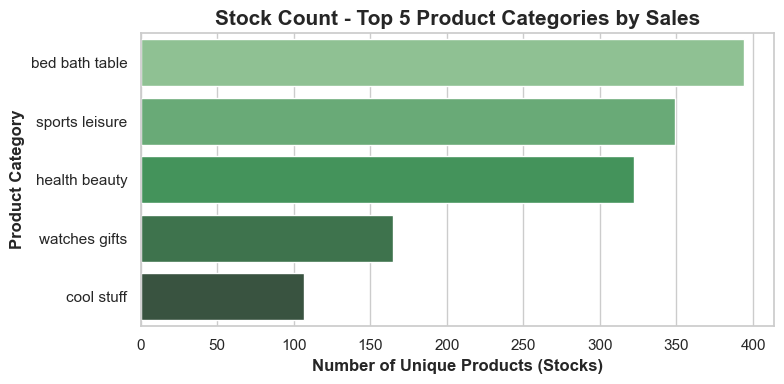

In [130]:
top_stock_counts = (
    top_df[top_df['product_category_name_english'].isin(top_5_sales['product_category_name_english'])]
    .groupby('product_category_name_english')['product_id']
    .nunique()
    .reset_index(name='stock_count')
    .sort_values(by='stock_count', ascending=False)
)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=top_stock_counts,
    x='stock_count',
    y='product_category_name_english',
    hue='product_category_name_english',
    palette='Greens_d',
    legend=False
)
plt.title('Stock Count - Top 5 Product Categories by Sales', fontsize=15, fontweight='bold')
plt.xlabel('Number of Unique Products (Stocks)', fontsize=12, fontweight='bold')
plt.ylabel('Product Category', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../visuals/stock_count-top_performers.png', dpi=600, bbox_inches='tight')
plt.show()


---

### **Stock Count - Underperforming Product Categories**

This chart shows how many different products (stock count) are available in the bottom 5 underperforming categories.

**Business Insight:**  
Underperforming categories have fewer products available, meaning there's less variety for customers to choose from. This limited selection, along with fewer sellers, makes these categories less visible and less competitive—leading to lower sales and fewer orders.

---


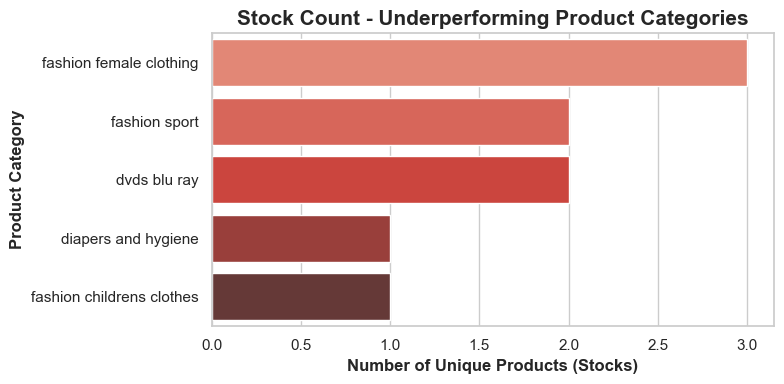

In [133]:
under_stock_counts = (
    underperforming_df[underperforming_df['product_category_name_english'].isin(under_5_sales['product_category_name_english'])]
    .groupby('product_category_name_english')['product_id']
    .nunique()
    .reset_index(name='stock_count')
    .sort_values(by='stock_count', ascending=False)
)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=under_stock_counts,
    x='stock_count',
    y='product_category_name_english',
    hue='product_category_name_english',
    palette='Reds_d',
    legend=False
)
plt.title('Stock Count - Underperforming Product Categories', fontsize=15, fontweight='bold')
plt.xlabel('Number of Unique Products (Stocks)', fontsize=12, fontweight='bold')
plt.ylabel('Product Category', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../visuals/stock_count-underperformers.png', dpi=600, bbox_inches='tight')
plt.show()


---

### Conclusion

This analysis focused on identifying the key differences between top-performing and underperforming product categories in an e-commerce dataset. Using SQL for data extraction and Python for visualization, the analyst compared seller count, order volume, and product variety to uncover factors driving performance.

**Key Observations:**

- Top categories exhibited significantly higher seller counts, stock variety, and order volumes.
- Underperforming categories consistently lacked seller presence and product diversity.
- These limitations directly correlate with their lower sales, suggesting visibility and competitiveness issues in the marketplace.

**Business Insight:**  
The low number of sellers and limited stock variety are the primary contributors to underperformance. These categories are less equipped to meet customer demand and lack the exposure needed to drive conversions.

This notebook highlights the analyst's ability to:
- Transition from SQL-prepared data to Python-based EDA
- Structure a clear comparison using visual storytelling
- Derive actionable insights relevant to marketplace optimization

---
